# Sommerakademie der Studienstiftung in Leysin 2023
## AG 8 Dynamik Evolutionärer Prozesse - Epistasis
 ---
Jeremias Boucsein, Solveig Tränkner, Noah Seelmann, Tengis Batmunkh, Benjamin Palm

## Funktionen und Import

In [158]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
from matplotlib.colors import LogNorm

index_to_base = {0: 'A', 1: 'C', 2: 'U', 3: 'G'}
base_to_number={'A':0, 'C':1, 'U':2, 'G':3, 'T':2}
db_to_bin = {'.': '00', '(': '10', ')': '01', '_': '00', '[': '10', ']': '01'}


def sequence_to_structure(seq, GPmap):
   return get_dotbracket_from_int(GPmap[sequence_str_to_int(seq)])

def sequence_str_to_int(sequence):
   """convert between sequence representations:
   from biological four-letter string to a tuple of integers from 0-3;
   motive: these integers can be used as array tuples"""
   return tuple([base_to_number[b] for b in sequence])

def sequence_tuple_to_str(sequence):
    return "".join([index_to_base[i] for i in sequence])

def get_dotbracket_from_int(structure_int):
   """ retrieve the full dotbracket string from the integer representation"""
   dotbracketstring = ''
   bin_to_db = {'10': '(', '00': '.', '01': ')'}
   structure_bin = bin(structure_int)[3:] # cut away '0b' and the starting 1
   assert len(structure_bin) % 2 == 0
   for indexpair in range(0, len(structure_bin), 2):
      dotbracketstring = dotbracketstring + bin_to_db[structure_bin[indexpair]+structure_bin[indexpair+1]]
   return dotbracketstring

def get_sequence_from_int(sequence_int):
    sequence_strukture = ''
    sequence_bin = bin(sequence_int)[2:] # cut away '0b'
    # fill in missing leading zeros
    while len(sequence_bin) < 26:
        sequence_bin = "0" + sequence_bin
    for i in range(0, len(sequence_bin), 2):
        sequence_strukture = sequence_strukture + index_to_base[int(sequence_bin[i]+sequence_bin[i+1], 2)]
    return sequence_strukture

def point_mutations(genotype):
    genotype = list(genotype)
    return (tuple(genotype[:i]+[g]+genotype[i+1:]) for i in range(len(genotype)) for g in set((0,1,2,3)) - {genotype[i]})

def neighbours(genotype, neutral_set):
    return [_ for _ in point_mutations(genotype) if _ in neutral_set]

def dfs(neutral_set, start=[]):
    if not start:
        start = neutral_set[0]
    U = [start]
    V = [start]
    while U:
        current_node = U[0]
        for n in neighbours(current_node, neutral_set):
            if n not in V:
                U.append(n)
                V.append(n)
        U = U[1:]
    return V

def dfs2(neutral_set, start=[]):
    if not start:
        start = neutral_set.pop()
    U = {start}
    V = {start}
    while U:
        current_node = U.pop()
        for n in neighbours(current_node, neutral_set):
            if n not in V:
                U.add(n)
                V.add(n)
    return V

def choose_random(n, neutral_set):
    l = len(neutral_set)
    total = set()
    while len(total) < n:
        total.add(neutral_set[random.randint(0, l-1)])
    return total

# Funktion um Epistase zweier Genotypen zu errechnen
def epistasis(genotype_1 , genotype_2, GPmap, phenotype_initial):
    epistasis_mutations = 0
    total_mutations = 0
    
    for i in range(13):
        for x in range(0, 4):
            if genotype_1[i] != x and genotype_2[i] != x:
                genotype_1_mutated = genotype_1[:i] + (x,) + genotype_1[i+1:]
                genotype_2_mutated = genotype_2[:i] + (x,) + genotype_2[i+1:]
                total_mutations += 1
                
                if (GPmap[genotype_1_mutated] == phenotype_initial and GPmap[genotype_2_mutated] != phenotype_initial) or (GPmap[genotype_2_mutated] == phenotype_initial and GPmap[genotype_1_mutated] != phenotype_initial):
                    epistasis_mutations += 1
    # print(total_mutations, epistasis_mutations)
    
    return epistasis_mutations/total_mutations

# Funktion um Hamming Distance zweier Genotypen zu errechnen
def hamming_distance(genotype_1, genotype_2):
    counter = 0
    for i in range(len(genotype_1)):
        if genotype_1[i] != genotype_2[i]:
            counter += 1
    return counter

def get_int_from_dotbracket(dotbracket_string): 
   # retrieve integer representation from dotbracket string
   dotbracket_binary = ''
   for index in range(len(dotbracket_string)): 
        dotbracket_binary = dotbracket_binary + db_to_bin[str(dotbracket_string[index])]
   dotbracket_binary = '1' + dotbracket_binary
   dotbracket_binary = int(dotbracket_binary, 2)
   return dotbracket_binary

def get_phenotype_index(phenotype, unique_phaenotypes_int): 
   return unique_phaenotypes_int.index(phenotype)

def get_neutral_set_size(phenotype, total, unique_phaenotypes_int): 
    phenotype_index = get_phenotype_index(phenotype, unique_phaenotypes_int)
    neutral_set = total[phenotype_index]
    return len(neutral_set)

    
##################################################################################################
##################################################################################################
print("RNA GP map: save data")
##################################################################################################
##################################################################################################

L = 13

#################################################
print("load")
#################################################
GPmap = np.load('GPmap_L'+str(L)+'mfe.npy')

#################################################
print("now we can use the GP map")
#################################################
seq_test = ''.join([np.random.choice(['A', 'G', 'C', 'G']) for i in range(L)])
print('this is how we can look up the structure for a sequence', seq_test, sequence_to_structure(seq_test, GPmap))

RNA GP map: save data
load
now we can use the GP map
this is how we can look up the structure for a sequence GAAGCCCAACACC .............


## Finden der neutral Sets

In [2]:
# mögliche Phänotypen finden
unique_phaenotypes_int = np.unique(GPmap)
unique_phaenotypes_int = list(unique_phaenotypes_int)
# spezifisch das Neutral Set ............. auschließen (da viel zu groß und uninteressant)
unique_phaenotypes_int.remove(67108864)

print("Suchen der Neutral Sets ...")

a = time.time() # zum Zeitmessen

# Die zu den Phänotypen zugehörigen Genotypen finden
# Liste der richtigen Länge initialisieren
total = list(np.zeros(len(unique_phaenotypes_int)))
for j, i in enumerate(unique_phaenotypes_int):
    genotypys_weird_format = np.where(GPmap==i)
    total[j] = list(zip(*genotypys_weird_format))
    
b = time.time() # zum Zeitmessen
    
print(f"Rechenzeit: {(b-a):.2f}s, Anzahl gefundener Neutral Sets: {len(total)}")

Suchen der Neutral Sets ...
Rechenzeit: 27.36s, Anzahl gefundener Neutral Sets: 49


## Auswählen welche Neutral Sets benutzt werden

In [3]:
# indices_neutral_sets_to_use = [28, 44, 36, 3, 48, 21, 43, 34, 45] # Indizes der zu benutzenden Phänotypen
indices_neutral_sets_to_use = [x for x in range(0, 49)] # alle :)

## Finden der neutral Components

In [4]:
neutral_components_by_phenotype = {} # Initialisieren des Dict in dem die Phänotypen mit ihren
                                     # Neutral Components gespeichert werden. 
                                     # Bsp: {67280917: [[(1, 0, 1, ...), (1, 3, 1, ...), ...], [(3, 0, 1, ...), (1, 1, 1, ...), ...]], 67764229: [...]}

# Berechnen der Neutral Components für die angegebenen Neutral Sets
for i in indices_neutral_sets_to_use:
    a = time.time() # zum Zeitmessen
    
    data_series = set(total[i]) # ein Neutral Set 

    print(f"Neutral Set zum Phänotyp {get_dotbracket_from_int(unique_phaenotypes_int[i])} mit Set-size: {len(data_series)}")
    print("Suchen der Neutral Components ...")

    list_comp = [] # Temporäre Liste in der die components gespeichert werden

    # Suchen der Neutral components
    while data_series:
        neutral_components = dfs2(data_series) # findet eine component
        list_comp.append(neutral_components) # zu Liste hinzufügen
        data_series = data_series - neutral_components # gefundenes component aus noch zu verarbeitenden Daten entfernen
        # print(f"Neutral Component gefunden mit Größe: {len(neutral_components)}")

    c = time.time() # zum Zeitmessen
    
    neutral_components_by_phenotype[unique_phaenotypes_int[i]] = list_comp

    print(f"Rechenzeit: {c-a:.2f}s, Anzahl gefundener Neutral Components: {len(list_comp)}")
    print("-------------------------------------------------------------------------------")

Neutral Set zum Phänotyp .....((....)) mit Set-size: 86933
Suchen der Neutral Components ...
Rechenzeit: 3.44s, Anzahl gefundener Neutral Components: 3
-------------------------------------------------------------------------------
Neutral Set zum Phänotyp ....((.....)) mit Set-size: 48792
Suchen der Neutral Components ...
Rechenzeit: 5.16s, Anzahl gefundener Neutral Components: 5
-------------------------------------------------------------------------------
Neutral Set zum Phänotyp ....((....)). mit Set-size: 297983
Suchen der Neutral Components ...
Rechenzeit: 18.32s, Anzahl gefundener Neutral Components: 6
-------------------------------------------------------------------------------
Neutral Set zum Phänotyp ....(((...))) mit Set-size: 122748
Suchen der Neutral Components ...
Rechenzeit: 22.83s, Anzahl gefundener Neutral Components: 10
-------------------------------------------------------------------------------
Neutral Set zum Phänotyp ...((......)) mit Set-size: 93441
Suchen d

Rechenzeit: 367.45s, Anzahl gefundener Neutral Components: 41
-------------------------------------------------------------------------------
Neutral Set zum Phänotyp ((.((...)).)) mit Set-size: 10596
Suchen der Neutral Components ...
Rechenzeit: 367.77s, Anzahl gefundener Neutral Components: 60
-------------------------------------------------------------------------------
Neutral Set zum Phänotyp ((.((...)))). mit Set-size: 7120
Suchen der Neutral Components ...
Rechenzeit: 367.98s, Anzahl gefundener Neutral Components: 26
-------------------------------------------------------------------------------
Neutral Set zum Phänotyp (((.......))) mit Set-size: 165008
Suchen der Neutral Components ...
Rechenzeit: 374.04s, Anzahl gefundener Neutral Components: 32
-------------------------------------------------------------------------------
Neutral Set zum Phänotyp (((......))). mit Set-size: 587796
Suchen der Neutral Components ...
Rechenzeit: 399.36s, Anzahl gefundener Neutral Components: 

## Epistasis und Hamming Distance berechnen

In [5]:
# Anzahl an i zufällig auszuwählenden Genotypen, für die Epistasis berechnet wird. 
# Auch die Anzahl j, mit der jeder der i Genotypen verglichen wird. (da Epsistase relatives Maß)
max_len = 100

master_dict_epistasis_by_hamming_distance = {} # Master Dict in dem für jeden Phänotyp ein Dict mit Hemming Distance 
                                               # und zugehörigen Epistasis Werten gespiechert ist

for l in indices_neutral_sets_to_use:
    
    list_comp = neutral_components_by_phenotype[unique_phaenotypes_int[l]]

    # initiieren des Dict in dem die Daten der Epistase nach Hamming Distance gespeichert werden
    epistasis_to_hamming = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[], 13:[]}

    a = time.time() # zum Zeitmessen

    # Loopen durch alle Neutral Components
    for i in list_comp:
        # random samplen von Genotypen
        for j in random.sample(i, len(i) if len(i) < max_len else max_len):
            # random samplen von Genotypen um diese mit den vorherig gesampleten Genotypen zu vergleichen
            for k in random.sample(i, len(i) if len(i) < max_len else max_len):
                # nicht zwei gleiche Genotypen miteinander vergleichen
                if j != k:
                    epistasis_percentage = epistasis(j, k, GPmap, unique_phaenotypes_int[3]) # Epistasis ausrechenen 
                    epistasis_to_hamming[hamming_distance(j, k)].append(epistasis_percentage) # Epistasis in Dict speichern

    b = time.time()
    print(f"Rechenzeit der Epistase für alle components bei phenotype {get_dotbracket_from_int(unique_phaenotypes_int[l])}: {b-a:.2f}s")
    
    master_dict_epistasis_by_hamming_distance[unique_phaenotypes_int[l]] = epistasis_to_hamming

/var/folders/7k/y24zml3s40jfns75f6hl9ffm0000gn/T/ipykernel_36338/1448374520.py:20: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for j in random.sample(i, len(i) if len(i) < max_len else max_len):
/var/folders/7k/y24zml3s40jfns75f6hl9ffm0000gn/T/ipykernel_36338/1448374520.py:22: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for k in random.sample(i, len(i) if len(i) < max_len else max_len):


Rechenzeit der Epistase für alle components bei phenotype .....((....)): 1.69s
Rechenzeit der Epistase für alle components bei phenotype ....((.....)): 2.59s
Rechenzeit der Epistase für alle components bei phenotype ....((....)).: 3.63s
Rechenzeit der Epistase für alle components bei phenotype ....(((...))): 6.09s
Rechenzeit der Epistase für alle components bei phenotype ...((......)): 2.99s
Rechenzeit der Epistase für alle components bei phenotype ...((.....)).: 2.26s
Rechenzeit der Epistase für alle components bei phenotype ...((....))..: 3.51s
Rechenzeit der Epistase für alle components bei phenotype ...(((....))): 8.15s
Rechenzeit der Epistase für alle components bei phenotype ...(((...))).: 10.18s
Rechenzeit der Epistase für alle components bei phenotype ..((.......)): 1.53s
Rechenzeit der Epistase für alle components bei phenotype ..((......)).: 4.43s
Rechenzeit der Epistase für alle components bei phenotype ..((.....))..: 2.19s
Rechenzeit der Epistase für alle components bei phe

## Plots

### "grid Plots"

In [256]:
number_plots = 16 # bestimmen wie viele der Phänotypen geplottet werden sollen
# zufällig auswählen
phenotypes_neutral_sets_selected = random.sample(unique_phaenotypes_int, number_plots)
indices_neutral_sets_selected = [get_phenotype_index(i, unique_phaenotypes_int) for i in phenotypes_neutral_sets_selected]

print(indices_neutral_sets_selected)

[24, 27, 5, 48, 22, 16, 31, 39, 23, 30, 32, 20, 44, 6, 36, 37]


In [257]:
# Grid berechnen
number_plots = len(indices_neutral_sets_selected)
number_plots_per_axis = math.ceil(np.sqrt(number_plots))

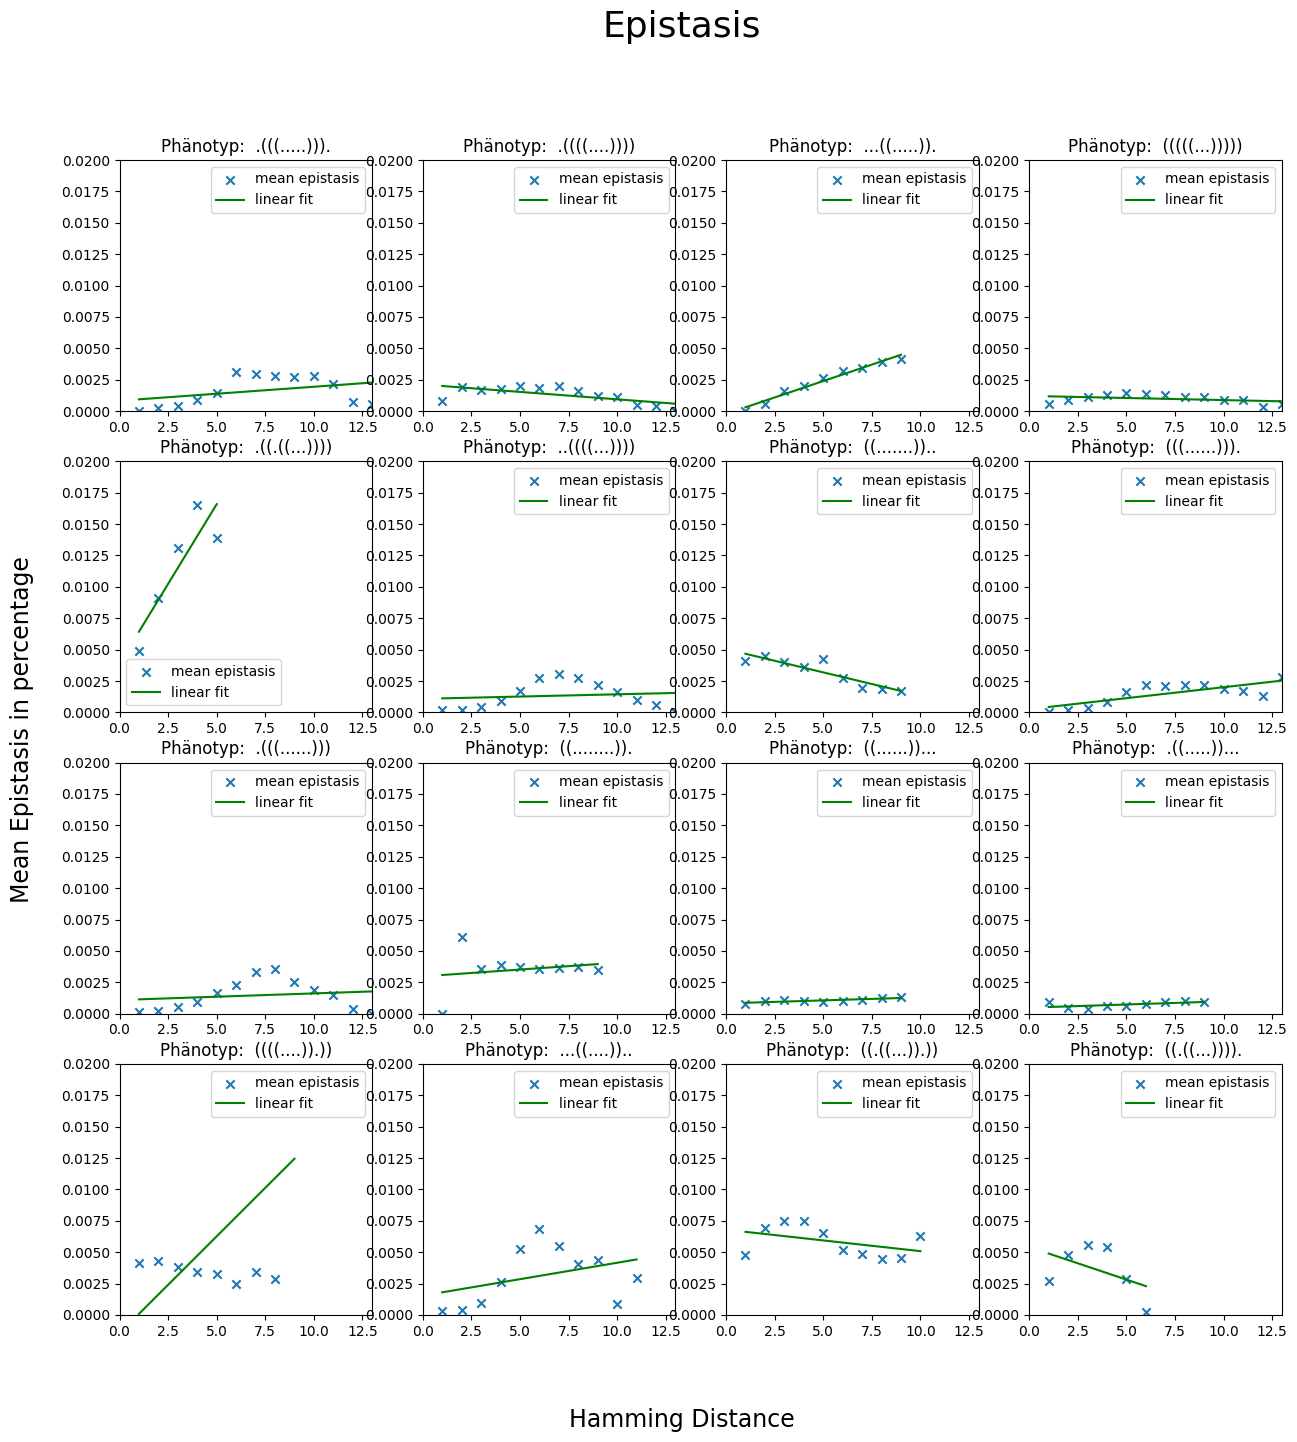

In [264]:
fig, axs = plt.subplots(number_plots_per_axis, number_plots_per_axis, figsize=(15, 15))

for index_1 in range(number_plots_per_axis):
    for index_2 in range(number_plots_per_axis):
        index_3 = int(str(index_1)+str(index_2), number_plots_per_axis)
        
        if index_3 < number_plots:
            
            epistasis_to_hamming = master_dict_epistasis_by_hamming_distance[unique_phaenotypes_int[indices_neutral_sets_selected[index_3]]]
            
            y_data = []
            x_data = []

            # X und Y Daten errechen: Mittelwerte für Y Werte bilden
            for i in epistasis_to_hamming:
                if len(epistasis_to_hamming[i]) > 0:
                    x_data.append(i)
                    y_data.append(sum(epistasis_to_hamming[i])/len(epistasis_to_hamming[i]))

            # Funktion für Fit
            def fitfunct(x, m, c):
                return m*x + c

            # Grade an Daten Fitten
            popt, pcov = curve_fit(fitfunct, x_data, y_data)
            x_fit = np.linspace(1, len(x_data), 100)

            # Plotten
            axs[index_1, index_2].set_title("Phänotyp:  " + get_dotbracket_from_int(unique_phaenotypes_int[indices_neutral_sets_selected[index_3]]))
            axs[index_1, index_2].set_xlim([0, 13])
            axs[index_1, index_2].set_ylim([0, 0.02])
            axs[index_1, index_2].scatter(x_data,y_data, marker="x", label="mean epistasis")
            axs[index_1, index_2].plot(x_fit, fitfunct(x_fit, *popt), c="g", label="linear fit")
            axs[index_1, index_2].legend()
            
fig.suptitle("Epistasis", fontsize=26)
fig.text(0.5, 0.04, 'Hamming Distance', ha='center', va='center', fontsize=17)
fig.text(0.06, 0.5, 'Mean Epistasis in percentage', ha='center', va='center', rotation='vertical', fontsize=17)  
plt.savefig("Epistasis_mean_vs_Hamming.pdf", format="pdf")
plt.show()

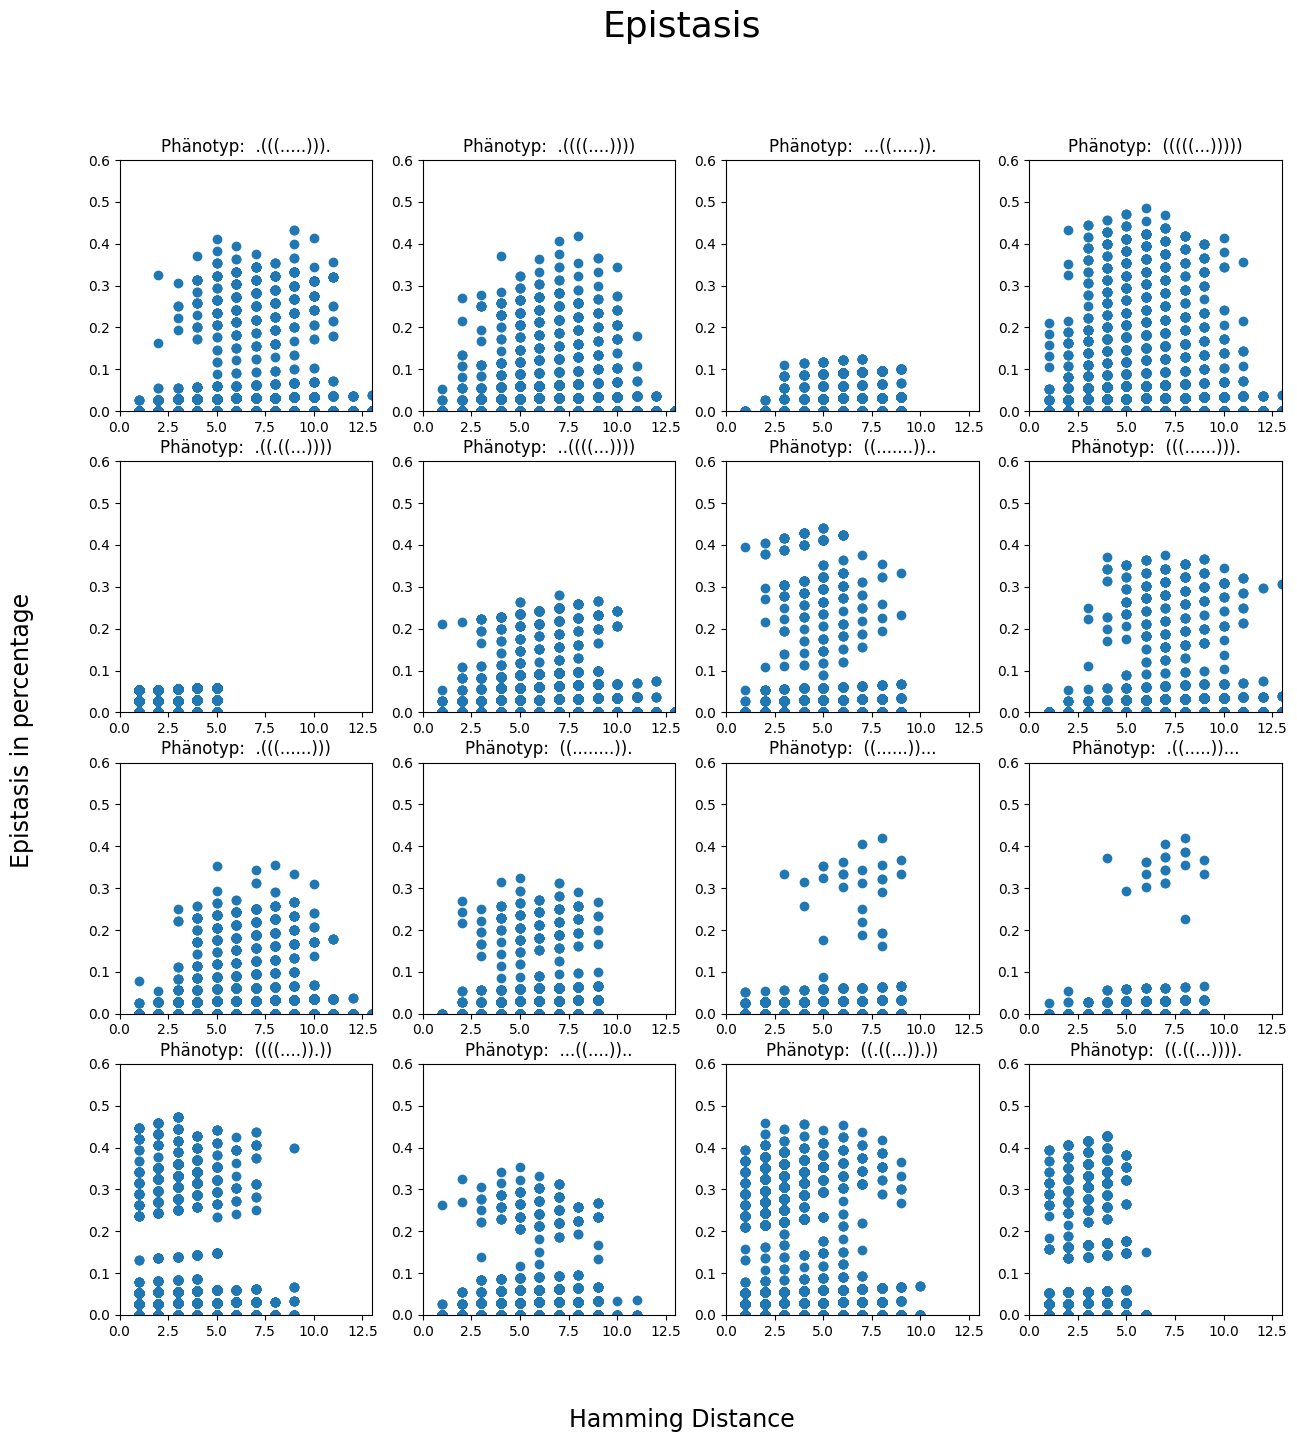

In [265]:
fig, axs = plt.subplots(number_plots_per_axis, number_plots_per_axis, figsize=(15, 15))

for index_1 in range(number_plots_per_axis):
    for index_2 in range(number_plots_per_axis):
        index_3 = int(str(index_1)+str(index_2), number_plots_per_axis)
        
        if index_3 < number_plots:
            
            epistasis_to_hamming = master_dict_epistasis_by_hamming_distance[unique_phaenotypes_int[indices_neutral_sets_selected[index_3]]]
            
            x_scatter_data = []
            y_scatter_data = []

            # X und Y Daten errechen: für jeden Y Datenpunkt den zugehörigen X Wert in Liste eintragen
            for i in epistasis_to_hamming:
                for j in range(len(epistasis_to_hamming[i])):
                    x_scatter_data.append(i)
                    y_scatter_data.append(epistasis_to_hamming[i][j])

            # Plotten
            axs[index_1, index_2].set_title("Phänotyp:  " + get_dotbracket_from_int(unique_phaenotypes_int[indices_neutral_sets_selected[index_3]]))
            axs[index_1, index_2].set_xlim([0, 13])
            axs[index_1, index_2].set_ylim([0, 0.6])
            axs[index_1, index_2].scatter(x_scatter_data, y_scatter_data)

fig.suptitle("Epistasis", fontsize=26)
fig.text(0.5, 0.04, 'Hamming Distance', ha='center', va='center', fontsize=17)
fig.text(0.06, 0.5, 'Epistasis in percentage', ha='center', va='center', rotation='vertical', fontsize=17)  
plt.savefig("Epistasis_vs_Hamming_scatter.pdf", format="pdf")
plt.show()

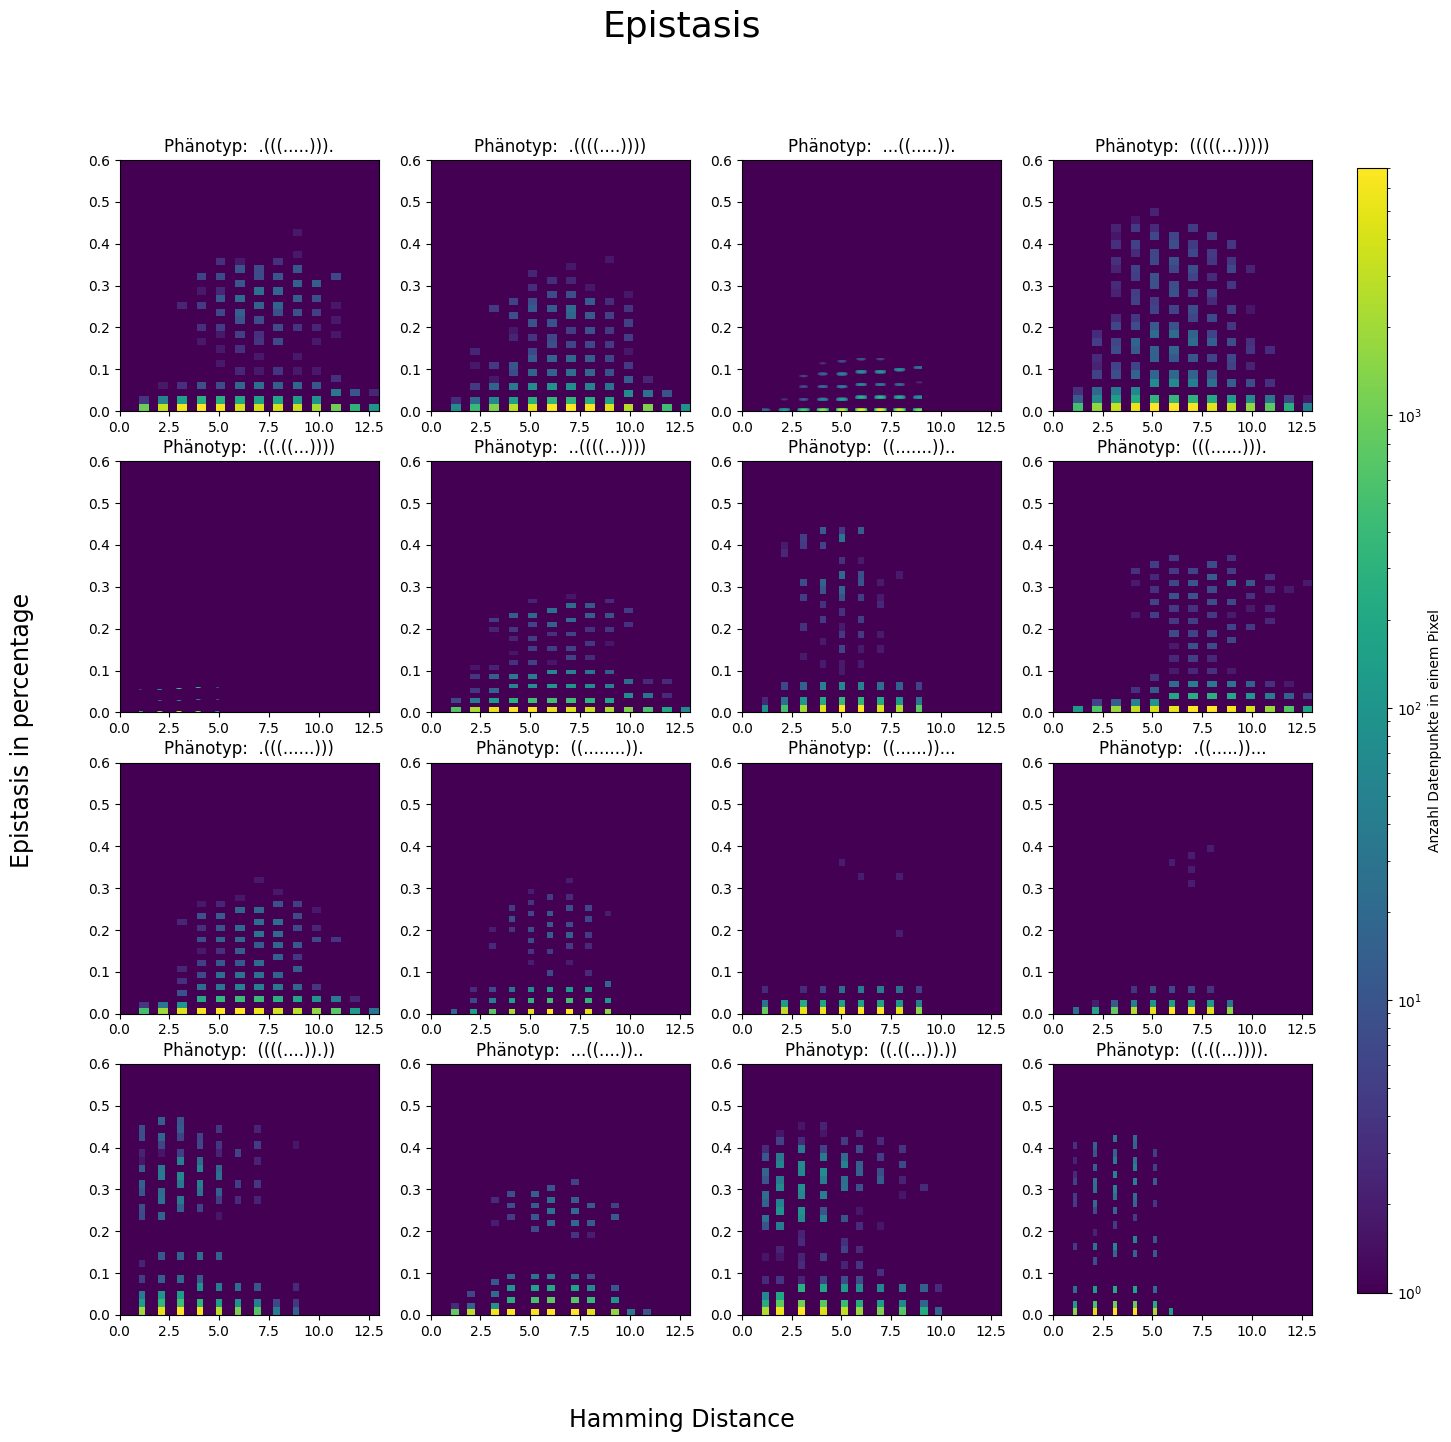

In [266]:
fig, axs = plt.subplots(number_plots_per_axis, number_plots_per_axis, figsize=(15, 15))

for index_1 in range(number_plots_per_axis):
    for index_2 in range(number_plots_per_axis):
        index_3 = int(str(index_1)+str(index_2), number_plots_per_axis)
        
        if index_3 < number_plots:
            
            epistasis_to_hamming = master_dict_epistasis_by_hamming_distance[unique_phaenotypes_int[indices_neutral_sets_selected[index_3]]]
            
            x_scatter_data = []
            y_scatter_data = []

            # X und Y Daten errechen: für jeden Y Datenpunkt den zugehörigen X Wert in Liste eintragen
            for i in epistasis_to_hamming:
                for j in range(len(epistasis_to_hamming[i])):
                    x_scatter_data.append(i)
                    y_scatter_data.append(epistasis_to_hamming[i][j])
            
            # Create heatmap
            num_bins = 25
            heatmap, xedges, yedges = np.histogram2d(x_scatter_data, y_scatter_data, bins=(num_bins, num_bins))
            extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
            
            axs[index_1, index_2].set_xlim([0,13])
            axs[index_1, index_2].set_ylim([0, 0.6])
            axs[index_1, index_2].imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm())
            axs[index_1, index_2].set_facecolor("#440154")
            axs[index_1, index_2].set_title("Phänotyp:  " + get_dotbracket_from_int(unique_phaenotypes_int[indices_neutral_sets_selected[index_3]]))

            
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.125, 0.02, 0.75])
fig.colorbar(im, cax=cbar_ax, label="Anzahl Datenpunkte in einem Pixel")
            
fig.suptitle("Epistasis", fontsize=26)
fig.text(0.5, 0.04, 'Hamming Distance', ha='center', va='center', fontsize=17)
fig.text(0.06, 0.5, 'Epistasis in percentage', ha='center', va='center', rotation='vertical', fontsize=17)   
plt.savefig("Epistasis_vs_Hamming_heat.pdf", format="pdf")
plt.show()

## Plotten der Anzahl von Elementen und Epistasis gegen Neutral Set

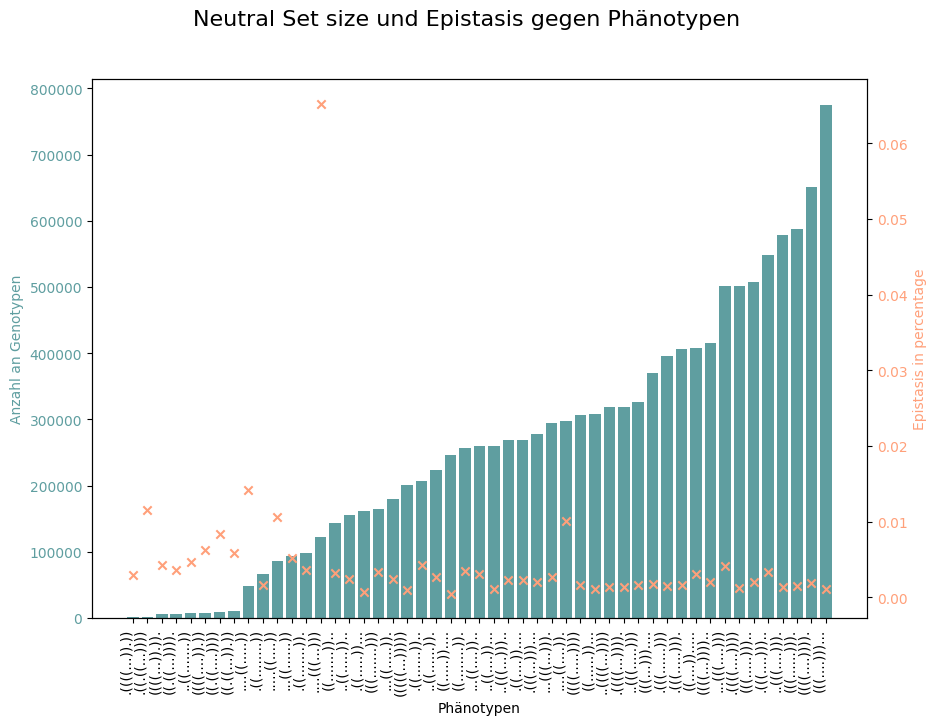

In [267]:
fig, ax1 = plt.subplots(figsize=(10,7))

################################# berechnen und Plotten Set size #################################

x_data_setsize = []
y_data_setsize = []

for i in range(len(unique_phaenotypes_int)):
    y_data_setsize.append(len(total[i]))
    x_data_setsize.append(get_dotbracket_from_int(unique_phaenotypes_int[i]))
    
y_data_setsize_sorted = []
x_data_setsize_sorted = []

zipped = sorted(zip(y_data_setsize, x_data_setsize))
for i in zipped:
    x_data_setsize_sorted.append(i[1])
    y_data_setsize_sorted.append(i[0])

ax1.set_xlabel("Phänotypen")
ax1.set_ylabel("Anzahl an Genotypen", color="cadetblue")
ax1.bar(x_data_setsize_sorted, y_data_setsize_sorted, width=0.8, color="cadetblue") 
ax1.tick_params(axis ='y', labelcolor = "cadetblue")

ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')

################################# berechnen und Plotten Epistasis #################################

ax2 = ax1.twinx()

x_data_mean_by_phenotype = []
y_data_mean_by_phenotype = []

 
for j in range(0, 49):
    
    epistasis_to_hamming = master_dict_epistasis_by_hamming_distance[unique_phaenotypes_int[j]]

    temp_mean = []

    # X und Y Daten errechen: Mittelwerte für Y Werte bilden
    for i in epistasis_to_hamming:
        if len(epistasis_to_hamming[i]) > 0:
            temp_mean.append(sum(epistasis_to_hamming[i])/len(epistasis_to_hamming[i]))

    y_data_mean_by_phenotype.append(sum(temp_mean)/len(temp_mean))
    x_data_mean_by_phenotype.append(get_neutral_set_size(unique_phaenotypes_int[j], total, unique_phaenotypes_int))
            
        
x_data_mean_by_phenotype_sorted = []
y_data_mean_by_phenotype_sorted = []

zipped = sorted(zip(x_data_mean_by_phenotype, y_data_mean_by_phenotype))
for i in zipped:
    x_data_mean_by_phenotype_sorted.append(str(i[0]))
    y_data_mean_by_phenotype_sorted.append(i[1])
        
ax2.set_ylabel("Epistasis in percentage", color = "lightsalmon")        

ax2.scatter(x_data_setsize_sorted, y_data_mean_by_phenotype_sorted, marker="x", color="lightsalmon")
ax2.tick_params(axis ='y', labelcolor = "lightsalmon")

#################################                            #################################

fig.suptitle("Neutral Set size und Epistasis gegen Phänotypen", fontsize=16)

plt.savefig("neutral_set_size_and_epistasis_vs_phenotypes.pdf", format="pdf")
plt.show()

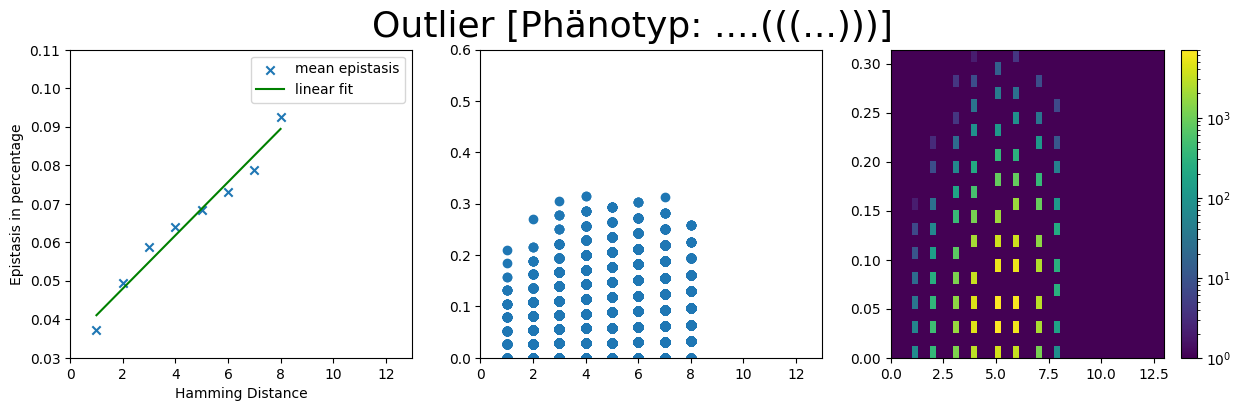

In [268]:
# Index des Outliers muss wegen der verwendeten Datenstruktur als Liste gespiechert werden
outlier = [3]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))


index_3 = 0
epistasis_to_hamming = master_dict_epistasis_by_hamming_distance[unique_phaenotypes_int[outlier[index_3]]]
           

################################# Erster Graph #################################
y_data = []
x_data = []

# X und Y Daten errechen: Mittelwerte für Y Werte bilden
for i in epistasis_to_hamming:
    if len(epistasis_to_hamming[i]) > 0:
        x_data.append(i)
        y_data.append(sum(epistasis_to_hamming[i])/len(epistasis_to_hamming[i]))

# Funktion für Fit
def fitfunct(x, m, c):
    return m*x + c

# Grade an Daten Fitten
popt, pcov = curve_fit(fitfunct, x_data, y_data)
x_fit = np.linspace(1, len(x_data), 100)

# Plotten
axs[0].set_xlabel("Hamming Distance")
axs[0].set_ylabel("Epistasis in percentage")
axs[0].set_xlim([0, 13])
axs[0].set_ylim([0.03, 0.11])
axs[0].scatter(x_data,y_data, marker="x", label="mean epistasis")
axs[0].plot(x_fit, fitfunct(x_fit, *popt), c="g", label="linear fit")
axs[0].legend()

################################# Zweiter Graph #################################

x_scatter_data = []
y_scatter_data = []

# X und Y Daten errechen: für jeden Y Datenpunkt den zugehörigen X Wert in Liste eintragen
for i in epistasis_to_hamming:
    for j in range(len(epistasis_to_hamming[i])):
        x_scatter_data.append(i)
        y_scatter_data.append(epistasis_to_hamming[i][j])

# Plotten
axs[1].set_xlim([0, 13])
axs[1].set_ylim([0, 0.6])
axs[1].scatter(x_scatter_data, y_scatter_data)

################################# Dritter Graph #################################

x_scatter_data = []
y_scatter_data = []

# X und Y Daten errechen: für jeden Y Datenpunkt den zugehörigen X Wert in Liste eintragen
for i in epistasis_to_hamming:
    for j in range(len(epistasis_to_hamming[i])):
        x_scatter_data.append(i)
        y_scatter_data.append(epistasis_to_hamming[i][j])

# Create heatmap
num_bins = 25
heatmap, xedges, yedges = np.histogram2d(x_scatter_data, y_scatter_data, bins=(num_bins, num_bins))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

axs[2].set_xlim([0,13])
im = axs[2].imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='viridis', norm=LogNorm())
axs[2].set_facecolor("#440154")
plt.colorbar(im, ax=axs[2])

fig.suptitle(f"Outlier [Phänotyp: {get_dotbracket_from_int(unique_phaenotypes_int[outlier[index_3]])}]", fontsize=26)
plt.savefig("outlier_index_3.pdf", format="pdf")
plt.show()